<a href="https://colab.research.google.com/github/maritnorli/IFCB_CNN_Classify/blob/main/CNN_transferlearning_IFCB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ***Connect to cuda and Mount Drive manually in Colab!!!***

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Copy files from drive to colab to work in colab

In [4]:
## Import the colab libraries and set up paths
from google.colab import drive
import os

## copy files from drive to colab
import shutil
# Specify the path to your "going_modular" folder in Google Drive
drive_path = "/content/drive/MyDrive/IFCB/going_modular"


# List files in the "going_modular" folder
files = os.listdir(drive_path)

# Copy each file individually to the /content directory
for file in files:
    src = os.path.join(drive_path, file)
    dst = os.path.join("/content", file)
    try:
        shutil.copy(src, dst)
    except Exception as e:
        print(f"Failed to copy {file}: {e}")

# wait a minute or so before it pops up

## 01. Prepare data

In [5]:
from pathlib import Path

# Set data paths
data_path = Path("/content/drive/MyDrive/IFCB/data/")
image_path = Path("/content/drive/MyDrive/IFCB/data/IFCB_test_train")

# Setup Dirs
train_dir = image_path / "Train"
test_dir = image_path / "Test"


In [6]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Now try importing modules directly from the copied drive files
try:
    import data_setup
    import engine

except ModuleNotFoundError as e:
    print(f"Failed to import modules: {e}")


[INFO] Couldn't find torchinfo... installing it.


In [7]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [8]:
#Create transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((244, 244)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [9]:
# Create training and testing dataloaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f9f1f5a9ab0>,
 ['Chaetoceros_decipiens_118',
  'Guinardia_delicatula_095',
  'Tripos_muelleri_008'])

### Get and prepare a pretrained model


In [10]:
# model = torchvision.models.efficientnet_b0(pretrained=True)

# New method of creating a pretrained model (torchvision v0.13+)
#weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # ".DEFAULT" = best available weights
model = torchvision.models.efficientnet_b0(pretrained=True).to(device)
#model #uncoment to output (its very long)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 68.5MB/s]


In [11]:
# Freeze all of the base layers in EffNetB0
for param in model.features.parameters():
  # print(param)
  param.requires_grad = False

In [12]:
# Update the classifier head of our model to suit our problem
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

#Recreate the classifier layer and seed it to the target device

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, # feature vector coming in
              out_features=output_shape,
              bias=True)).to(device) # how many classes do we have?

#model.classifier

### Train model

In [13]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [14]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8563 | train_acc: 0.6905 | test_loss: 0.5773 | test_acc: 1.0000
Epoch: 2 | train_loss: 0.4929 | train_acc: 0.9162 | test_loss: 0.4684 | test_acc: 1.0000
Epoch: 3 | train_loss: 0.2696 | train_acc: 0.9742 | test_loss: 0.3820 | test_acc: 1.0000
Epoch: 4 | train_loss: 0.1889 | train_acc: 0.9831 | test_loss: 0.2751 | test_acc: 1.0000
Epoch: 5 | train_loss: 0.1488 | train_acc: 0.9955 | test_loss: 0.2112 | test_acc: 1.0000
[INFO] Total training time: 64.709 seconds


### Make predictions on the entire test dataset with the model

In [18]:
from tqdm.auto import tqdm
# Make predictions on the entire test dataset
test_preds = []
model.eval()
print(f"Length of test dataloader is {len(test_dataloader)} batches")

with torch.inference_mode():
  #loop through the batches in the test dataloader
  for X, y in tqdm(test_dataloader):
    X, y = X.to(device), y.to(device)
    # PAss the data through the model
    test_logits = model(X)

    #convert the pred logits to pred probs
    pred_probs = torch.softmax(test_logits, dim=1)

    #convert the pred probs into pred labels
    pred_labels = torch.argmax(pred_probs, dim=1)

    # Add the pred labels to test preds list
    test_preds.append(pred_labels)

# Concatenate the test preds and put them on the cpu
test_preds = torch.cat(test_preds).cpu()
test_preds

Length of test dataloader is 2 batches


  0%|          | 0/2 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

### Make a cunfusion matrix with the test preds and the truth labels


In [20]:
#get the truth labels for test dataset
test_truth = torch.cat([y for X, y in test_dataloader])
test_truth

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

Need the following libraries to make a cinfusion matrix
* torchmetrics
* mlxtend

In [21]:
# See if torchmetrics is installed and if not, install...
try:
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1] >= 19, "mlxtend version should be 0.19.0 or higher")
except:
  !pip install torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 87.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 823.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

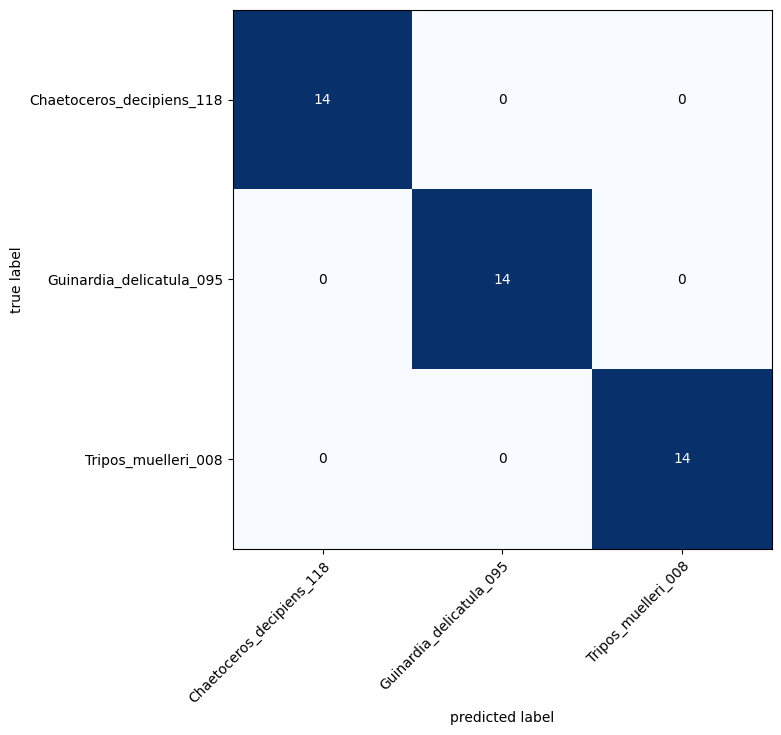

In [23]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task="multiclass")
confmat_tensor = confmat(preds=test_preds,
                         target=test_truth)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with numpy
    class_names=class_names,
    figsize=(10, 7)
)



### Code for plotting the most wrong images


In [24]:
# Create a dataframe with sample, label, prediction, pred probs


# Get all test data paths
# get a list of all the samples (paths)

from pathlib import Path
test_data_paths = list(Path(test_dir).glob("*/*.png"))
test_labels = [path.parent.stem for path in test_data_paths]

# create a function to return a list of dictionaries with sample, label prediction, pred probs
def pred_and_store(test_paths, model, transform):
  test_pred_list = []
  for path in test_paths:
    # Create empty dict to store info for each sample
    pred_dict = {}

    #Get sample path
    pred_dict["image_path"] = path

    # Get class name
    pred_dict["class_name"] = path.parent.stem

    #Get prediction
    from PIL import Image #open image
    img = image.open(path)transform_image = transform(img).unsqueeze(0) #transform image and add batch dimension
    model.eval()






[PosixPath('/content/drive/MyDrive/IFCB/data/IFCB_test_train/Test/Chaetoceros_decipiens_118/D20230505T131754_IFCB139_00015.png'),
 PosixPath('/content/drive/MyDrive/IFCB/data/IFCB_test_train/Test/Chaetoceros_decipiens_118/D20230505T113231_IFCB139_00009.png'),
 PosixPath('/content/drive/MyDrive/IFCB/data/IFCB_test_train/Test/Chaetoceros_decipiens_118/D20230505T121441_IFCB139_00013.png'),
 PosixPath('/content/drive/MyDrive/IFCB/data/IFCB_test_train/Test/Chaetoceros_decipiens_118/D20230505T105022_IFCB139_00012.png'),
 PosixPath('/content/drive/MyDrive/IFCB/data/IFCB_test_train/Test/Chaetoceros_decipiens_118/D20230505T121441_IFCB139_00005.png'),
 PosixPath('/content/drive/MyDrive/IFCB/data/IFCB_test_train/Test/Chaetoceros_decipiens_118/D20230505T125650_IFCB139_00009.png'),
 PosixPath('/content/drive/MyDrive/IFCB/data/IFCB_test_train/Test/Chaetoceros_decipiens_118/D20230505T111127_IFCB139_00007.png'),
 PosixPath('/content/drive/MyDrive/IFCB/data/IFCB_test_train/Test/Chaetoceros_decipiens_11